In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Загрузим датасеты

In [2]:
dtypes = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

In [3]:
train = pd.read_csv('data/train.csv', dtype=dtypes)
lectures = pd.read_csv('data/lectures.csv')
questions = pd.read_csv('data/questions.csv')

### Удалим ненужный стобец

In [4]:
train = train.drop(['row_id'], axis=1)

### Посмотрим на датасеты

In [5]:
train

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...
101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


In [6]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [7]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


### Можно заметить, что основной датасет train огромный: 101 миллион строк. Нам придётся использовать словари, чтобы обрабатывать всю эту информацию быстро

In [8]:
d_parts = {questions.iloc[i, 0]: questions.iloc[i, 3] for i in range(len(questions))}

In [9]:
content_type_questions = set(train[train.content_type_id == 0].index)

### Узнаем, к какой части относится каждый вопрос

In [10]:
d_content_id = dict(zip(list(range(len(train))), train.content_id.values.tolist()))

In [11]:
parts = []
for i in tqdm(range(len(train))):
    if i in content_type_questions:
        parts.append(d_parts[d_content_id[i]])
    else:
        parts.append(-1)

100%|██████████| 101230332/101230332 [00:14<00:00, 6964338.51it/s]


In [12]:
parts = np.array(parts)
assert (parts != -1).sum() == len(train[train.content_type_id == 0])

In [13]:
train['parts'] = parts

### Посмотрим на общее распределение ответов

<Axes: >

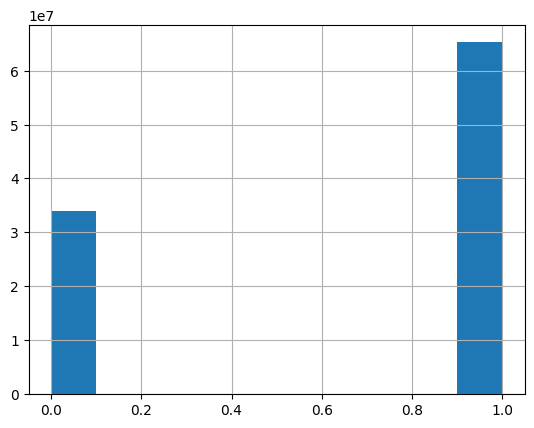

In [14]:
train[train.content_type_id == 0].answered_correctly.hist()

### Посмотрим на распределение вопросов по частям: видно, что 5 часть самая обширная

<Axes: >

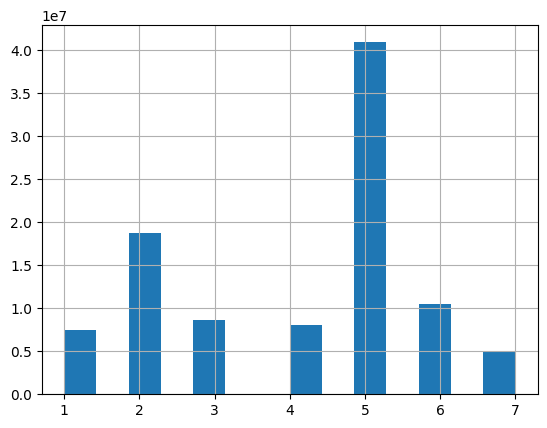

In [15]:
train[train.parts != -1].parts.hist(bins=14)

### Посмотрим на статистику правильности ответов на вопросы по каждой из частей: 5 самая массовая часть имеет худший результат, а первая часть - лучший

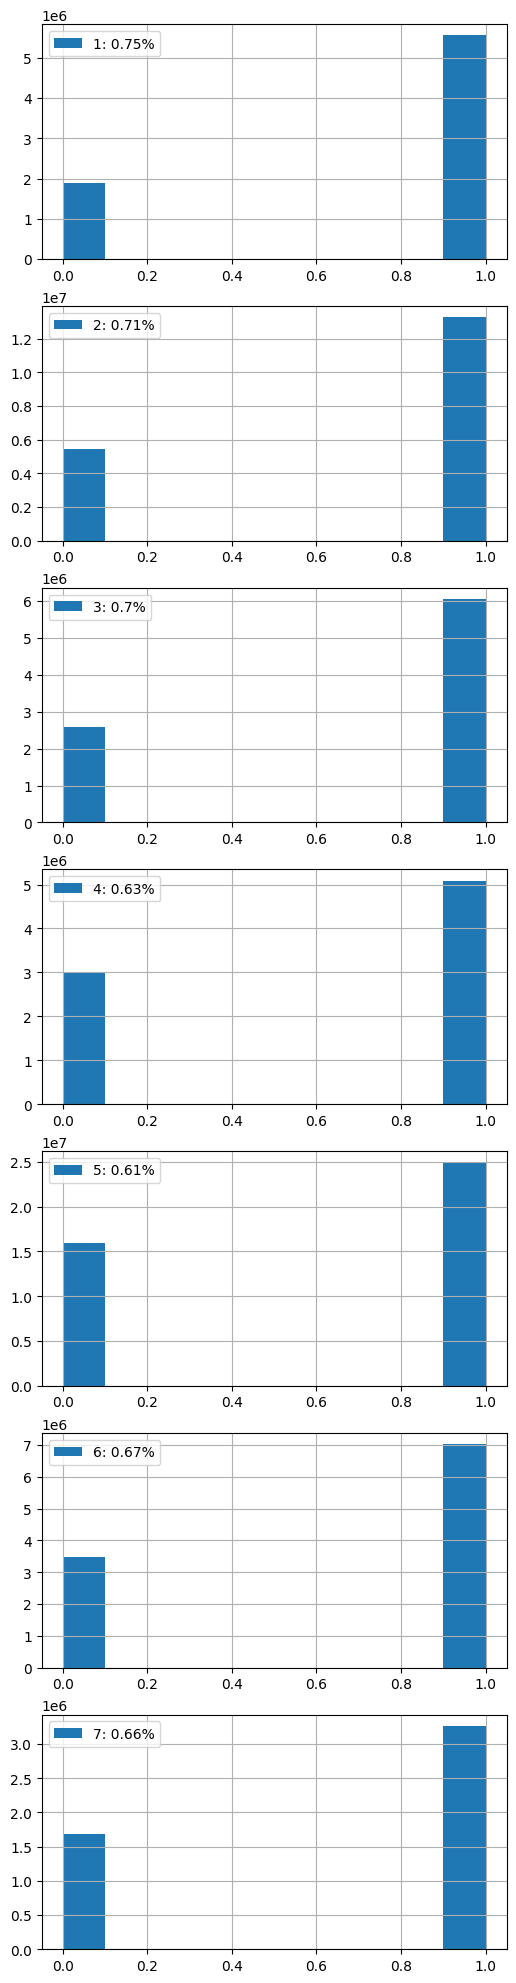

In [16]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(6, 25))
for i in range(1, 8):
    train[train.parts == i].answered_correctly.hist(ax=ax[i-1])
    correct = (train[train.parts == i].answered_correctly == 1).sum()
    all = train[train.parts == i].shape[0]
    perc_correct = round(correct / all, 2)
    ax[i-1].legend([f'{i}: {perc_correct}%'])

### К сожалению, ни часть вопроса, ни время, затраченное на него не влияет на целевую переменную

In [17]:
train_temp = train[train.content_type_id == 0]

In [18]:
train_temp.parts.corr(train_temp.answered_correctly)

-0.07505331429579741

In [19]:
train_temp.prior_question_elapsed_time.corr(train_temp.answered_correctly)

-0.007900239787032895

### Теперь посмотрим, смотрел ли пользователь лекцию по теме вопроса. Конечно, тут нужно много словарей, чтобы это работало не 30 часов

In [20]:
train_temp = train[train.content_type_id == 1]

In [21]:
d_lecture_parts = {}
for i in tqdm(range(len(lectures))):
    d_lecture_parts[lectures.iloc[i, 0]] = lectures.iloc[i, 2]

100%|██████████| 418/418 [00:00<00:00, 58256.16it/s]


In [22]:
d_users_watched_lectures = {}
for x in tqdm(train.user_id.unique()):
    d_users_watched_lectures[x] = set()
for i in tqdm(range(len(train_temp))):
    d_users_watched_lectures[train_temp.iloc[i, 1]].add(d_lecture_parts[train_temp.iloc[i, 2]])

100%|██████████| 1959032/1959032 [00:32<00:00, 59980.50it/s]


In [23]:
d_users = dict(zip(list(range(len(train))), train.user_id.values.tolist()))

In [24]:
watched_lecture = []
for i in tqdm(range(len(train))):
    if i in content_type_questions:
        watched = int(parts[i] in d_users_watched_lectures[d_users[i]])
        watched_lecture.append(watched)
    else:
        watched_lecture.append(-1)

  0%|          | 0/101230332 [00:00<?, ?it/s]

100%|██████████| 101230332/101230332 [01:45<00:00, 956885.29it/s]


In [25]:
train['watched_lecture'] = watched_lecture

### Но данная переменная почему-то тоже никак не влияет на целевую переменную

In [26]:
train_temp = train[train.content_type_id == 0]

In [27]:
train_temp.watched_lecture.corr(train_temp.answered_correctly)

0.03628232049951815